# Case Study 
# Macroeconomic Model: House Price Index Model



## Business Objective

In the finance industry, fixed income securities like Residential Mortgage-Backed Securities (RMBS) rely heavily on accurate predictions of the House Price Index (HPI). Understanding the factors that influence house prices is crucial for investors and policymakers. As of 2022, the size of the global fixed-income market was 129.8 trillion USD, compared to the global equity market, which was 101.2 trillion USD. This case study aims to develop a robust model to predict the S&P/Case-Shiller U.S. National Home Price Index using various macroeconomic variables.

Source: Securities Industry and Financial Markets Association


# Model Overview

### Dependent Variable (Y)
- S&P/Case-Shiller U.S. National Home Price Index

### Independent Variables (X)
As potential explanatory variables:
1. 30-Year Fixed Rate Mortgage Average in the United States
2. Interest Rates and Price Indexes; 10-Year Treasury Yield, Level
3. Federal Funds Effective Rate
4. All Employees, Retail Trade
5. Real Gross Domestic Product
6. Median Consumer Price Index
7. Unemployment Rate
8. Retail Sales: Building Materials and Supplies Dealers
9. University of Michigan: Consumer Sentiment

## Key Questions Before Building the Model

- Are there any variables that can be ruled out as having not much incremental explanatory value?
- What approach would be best to analyze this data?
- Are there any assumptions required for this approach or model?


## Interpretation of Results
- Model Coefficients: Indicates the change in the dependent variable for a one-unit change in an independent variable, holding all other variables constant.
- R-Squared: Represents the proportion of the variance in the dependent variable explained by the model.

In [1]:
#!pip install matplotlib==3.8.4

In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
variables = ['MORTGAGE30US', 'DGS10', 'FEDFUNDS', 'PAYEMS', 'CPIAUCSL', 'UNRATE', 'UMCSENT','CSUSHPINSA']
data = pd.DataFrame()

for var in variables:
    data = data.join(web.DataReader(var, 'fred', start='1988-01-01', end='2024-06-30').resample('M').mean(), how='outer')


data = data.rename(columns={'MORTGAGE30US': '30-Year Fixed Rate Mortgage',
                            'DGS10': '10-Year Treasury Yield',
                            'FEDFUNDS': 'Federal Funds Rate',
                            'PAYEMS': 'All Employees, Retail Trade',
                            'CPIAUCSL': 'Median CPI',
                            'UNRATE': 'Unemployment Rate',
                            'UMCSENT': 'Consumer Sentiment',
                            'CSUSHPINSA':'House Price'})

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 438 entries, 1988-01-31 to 2024-06-30
Freq: M
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   30-Year Fixed Rate Mortgage  438 non-null    float64
 1   10-Year Treasury Yield       438 non-null    float64
 2   Federal Funds Rate           438 non-null    float64
 3   All Employees, Retail Trade  438 non-null    float64
 4   Median CPI                   438 non-null    float64
 5   Unemployment Rate            438 non-null    float64
 6   Consumer Sentiment           437 non-null    float64
 7   House Price                  436 non-null    float64
dtypes: float64(8)
memory usage: 30.8 KB


In [6]:
data.isnull().sum()

30-Year Fixed Rate Mortgage    0
10-Year Treasury Yield         0
Federal Funds Rate             0
All Employees, Retail Trade    0
Median CPI                     0
Unemployment Rate              0
Consumer Sentiment             1
House Price                    2
dtype: int64

In [7]:
data.ffill(inplace=True)

In [8]:
data.head()

,30-Year Fixed Rate Mortgage,10-Year Treasury Yield,Federal Funds Rate,"All Employees, Retail Trade",Median CPI,Unemployment Rate,Consumer Sentiment,House Price
DATE,,,,,,,,
1988-01-31,10.3825,8.665789,6.83,103753.0,116.0,5.7,90.8,68.582
1988-02-29,9.8925,8.212000,6.58,104214.0,116.2,5.7,91.6,68.914
1988-03-31,9.9300,8.373478,6.58,104489.0,116.5,5.7,94.6,69.323
1988-04-30,10.2020,8.718500,6.87,104732.0,117.2,5.4,91.2,69.789
1988-05-31,10.4550,9.089048,7.09,104962.0,117.5,5.6,94.8,70.409


In [9]:
data.tail()

,30-Year Fixed Rate Mortgage,10-Year Treasury Yield,Federal Funds Rate,"All Employees, Retail Trade",Median CPI,Unemployment Rate,Consumer Sentiment,House Price
DATE,,,,,,,,
2024-02-29,6.7760,4.207500,5.33,157796.0,311.054,3.9,76.9,312.629
2024-03-31,6.8200,4.208500,5.33,158106.0,312.230,3.8,79.4,316.707
2024-04-30,6.9925,4.539091,5.33,158214.0,313.207,3.9,77.2,320.419
2024-05-31,7.0600,4.482273,5.33,158432.0,313.225,4.0,69.1,320.419
2024-06-30,6.9175,4.305263,5.33,158638.0,313.049,4.1,69.1,320.419


In [10]:
data.describe()

,30-Year Fixed Rate Mortgage,10-Year Treasury Yield,Federal Funds Rate,"All Employees, Retail Trade",Median CPI,Unemployment Rate,Consumer Sentiment,House Price
count,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000
mean,6.227592,4.493646,3.116370,131373.036530,200.868708,5.716438,85.867352,147.553824
std,2.075853,2.174734,2.641069,13957.132768,49.951213,1.705478,13.068515,64.855523
min,2.684000,0.623636,0.050000,103753.000000,116.000000,3.400000,50.000000,68.582000
25%,4.309375,2.623837,0.332500,121753.500000,159.725000,4.500000,76.400000,83.753500
50%,6.259750,4.259941,2.940000,132200.500000,200.200000,5.400000,89.000000,143.959500
75%,7.623000,6.035125,5.297500,140513.000000,237.472750,6.575000,95.075000,182.076000
max,11.050000,9.357727,9.850000,158638.000000,313.225000,14.800000,112.000000,320.419000


In [11]:
data.corr()

,30-Year Fixed Rate Mortgage,10-Year Treasury Yield,Federal Funds Rate,"All Employees, Retail Trade",Median CPI,Unemployment Rate,Consumer Sentiment,House Price
30-Year Fixed Rate Mortgage,1.000000,0.985564,0.895144,-0.757489,-0.785129,-0.167629,0.215332,-0.626023
10-Year Treasury Yield,0.985564,1.000000,0.868972,-0.818381,-0.844546,-0.124164,0.274283,-0.699890
Federal Funds Rate,0.895144,0.868972,1.000000,-0.546379,-0.620095,-0.400770,0.337799,-0.442773
"All Employees, Retail Trade",-0.757489,-0.818381,-0.546379,1.000000,0.945416,-0.339528,-0.177788,0.903649
Median CPI,-0.785129,-0.844546,-0.620095,0.945416,1.000000,-0.123386,-0.397756,0.946951
Unemployment Rate,-0.167629,-0.124164,-0.400770,-0.339528,-0.123386,1.000000,-0.442719,-0.264023
Consumer Sentiment,0.215332,0.274283,0.337799,-0.177788,-0.397756,-0.442719,1.000000,-0.407180
House Price,-0.626023,-0.699890,-0.442773,0.903649,0.946951,-0.264023,-0.407180,1.000000


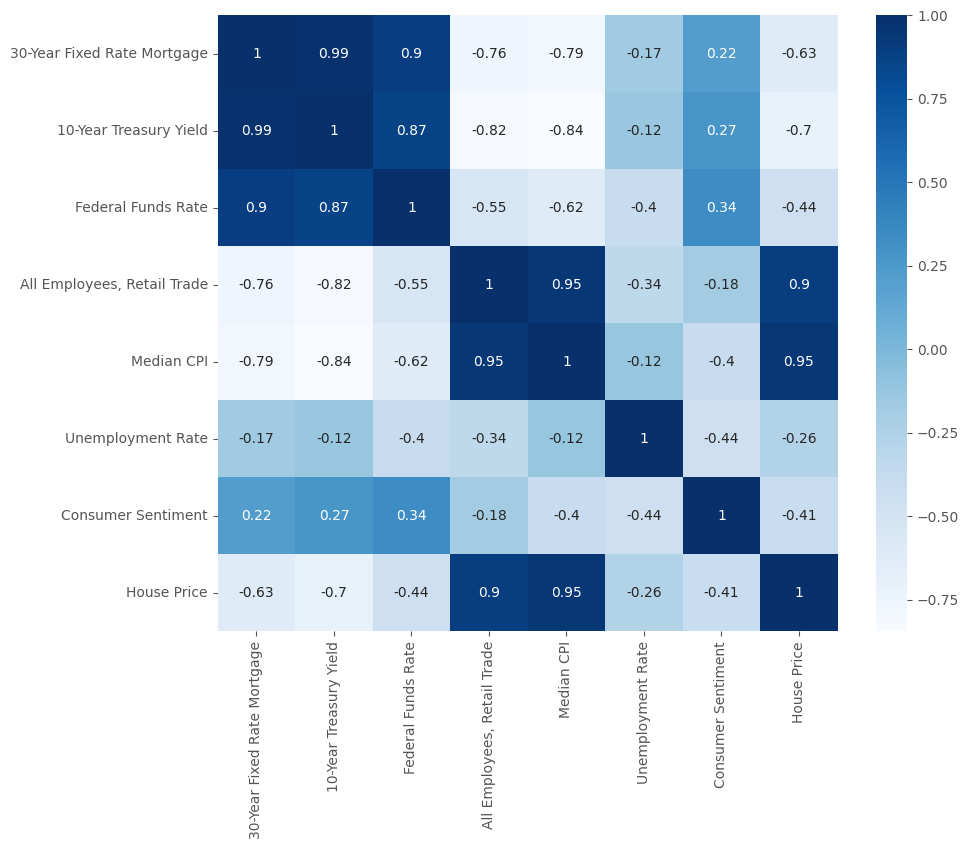

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='Blues')
plt.show()

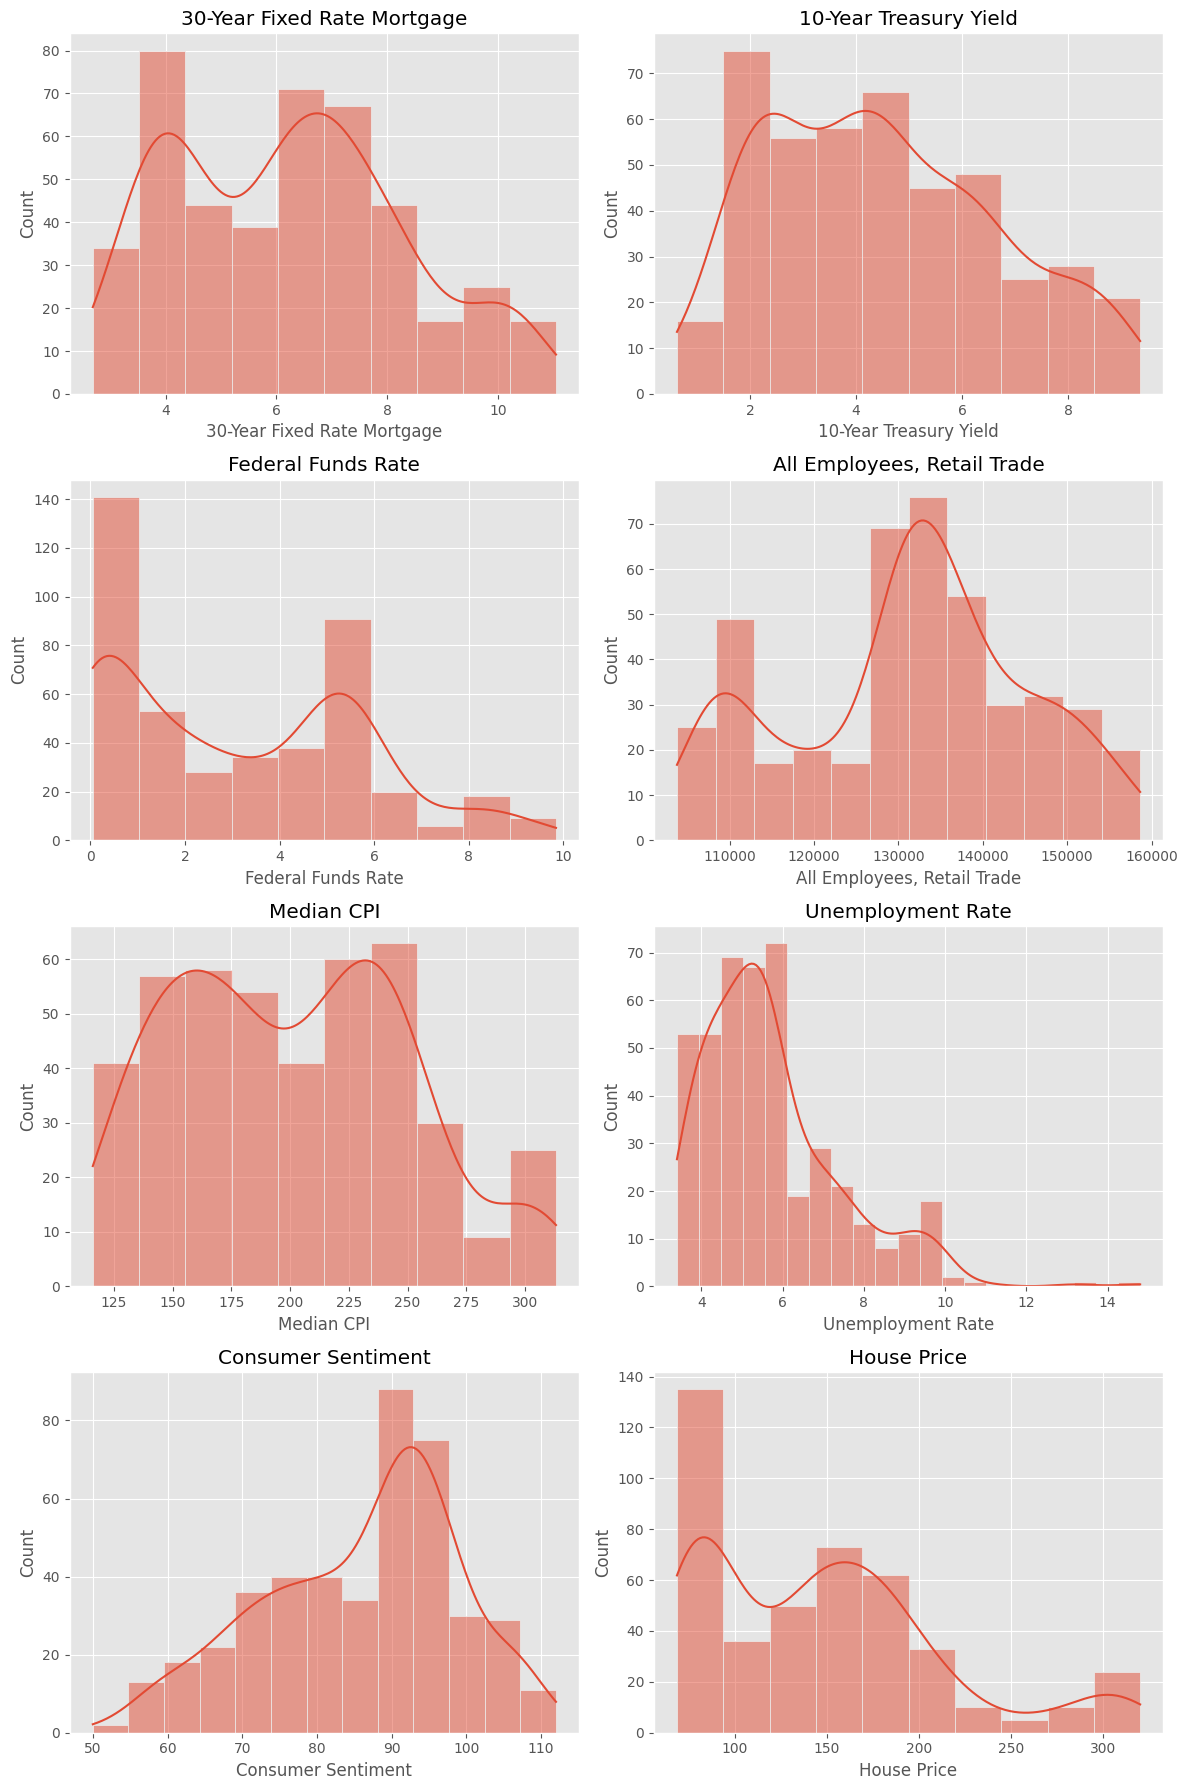

In [13]:
# Histogram and density plots
fig, axs = plt.subplots(4, 2, figsize=(12, 18))
axs = axs.flatten()
for i, var in enumerate(data.columns):
    sns.histplot(data[var], kde=True, ax=axs[i])
    axs[i].set_title(var)
plt.tight_layout()
plt.show()

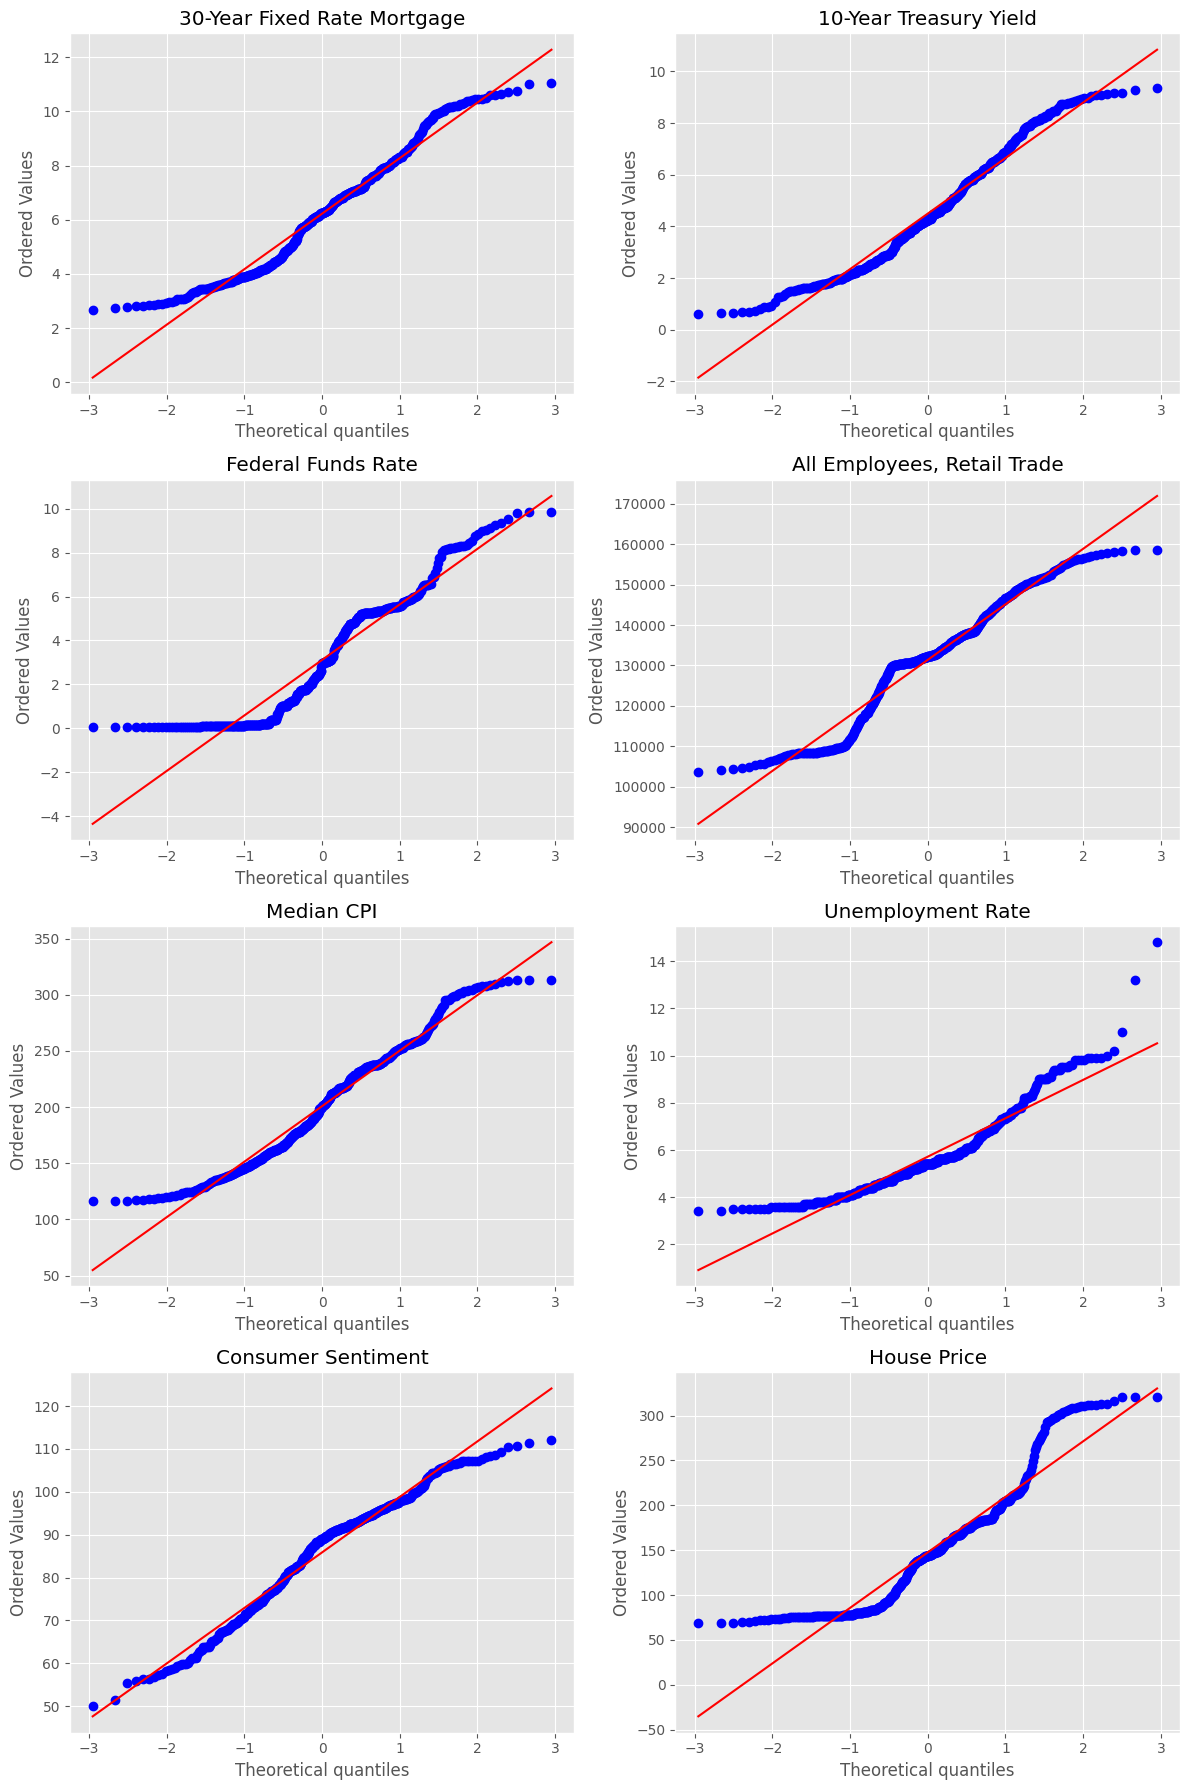

In [14]:
# Q-Q plots
fig, axs = plt.subplots(4, 2, figsize=(12, 18))
axs = axs.flatten()
for i, var in enumerate(data.columns):
    stats.probplot(data[var], plot=axs[i])
    axs[i].set_title(var)
plt.tight_layout()
plt.show()

In [15]:
end_date = data.index.max()
start_test_date = end_date - pd.DateOffset(years=2)

train = data[data.index < start_test_date]
test = data[data.index >= start_test_date]

X_train = train.drop(columns='House Price')
y_train = train['House Price']
X_test = test.drop(columns='House Price')
y_test = test['House Price']

In [16]:
X_train_with_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            House Price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     610.1
Date:                Wed, 24 Jul 2024   Prob (F-statistic):          1.06e-210
Time:                        02:44:44   Log-Likelihood:                -1720.8
No. Observations:                 413   AIC:                             3458.
Df Residuals:                     405   BIC:                             3490.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [17]:
X_test_with_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_const)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 175.29451769932115


In [18]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_with_const.values, i) for i in range(X_train_with_const.shape[1])]
vif_data

,Feature,VIF
0,const,2704.035412
1,30-Year Fixed Rate Mortgage,98.349191
2,10-Year Treasury Yield,91.164200
3,Federal Funds Rate,8.152345
4,"All Employees, Retail Trade",30.469287
5,Median CPI,31.619095
6,Unemployment Rate,4.487420
7,Consumer Sentiment,2.670723


- We are using Ridge regression because our data exhibits multicollinearity, where predictors are highly correlated. Ridge regression helps manage this issue by shrinking the coefficients of correlated features, thereby reducing their impact while keeping all predictors in the model. This approach improves the model's stability and performance in the presence of multicollinearity.

- We did not drop variables one by one because our goal was to address multicollinearity and improve model stability, rather than manually selecting features. Ridge regression allows us to regularize all features simultaneously, reducing their impact in a controlled manner. This approach is more systematic and avoids the potential pitfalls of subjective feature selection, such as losing important information or introducing bias.

In [19]:
# regularization with Ridge and Lasso regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_with_const.drop(columns=['const']))
X_test_scaled = scaler.transform(X_test_with_const.drop(columns=['const']))

ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

ridge.fit(X_scaled, y_train)
lasso.fit(X_scaled, y_train)

ridge_pred = ridge.predict(X_test_scaled)
lasso_pred = lasso.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, ridge_pred)
lasso_mse = mean_squared_error(y_test, lasso_pred)

print(f'Ridge Mean Squared Error: {ridge_mse}')
print(f'Lasso Mean Squared Error: {lasso_mse}')

Ridge Mean Squared Error: 87.72855686351063
Lasso Mean Squared Error: 72.62285746404122


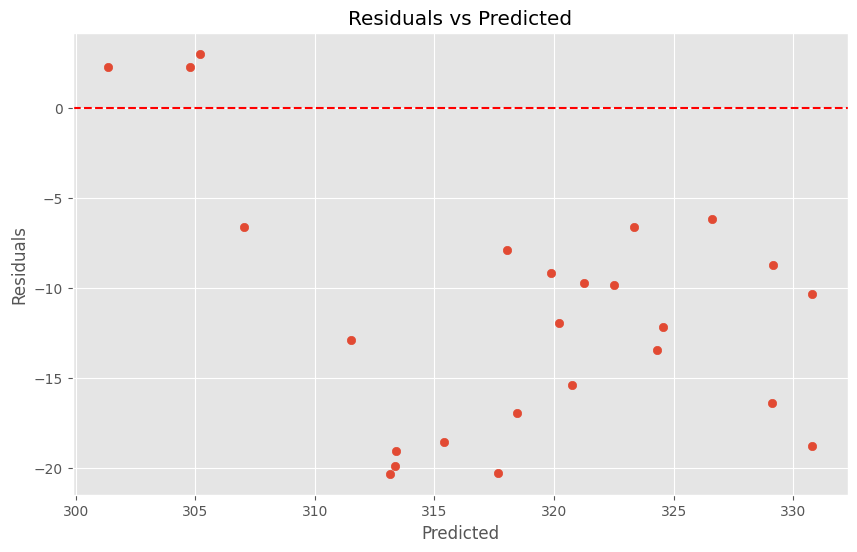

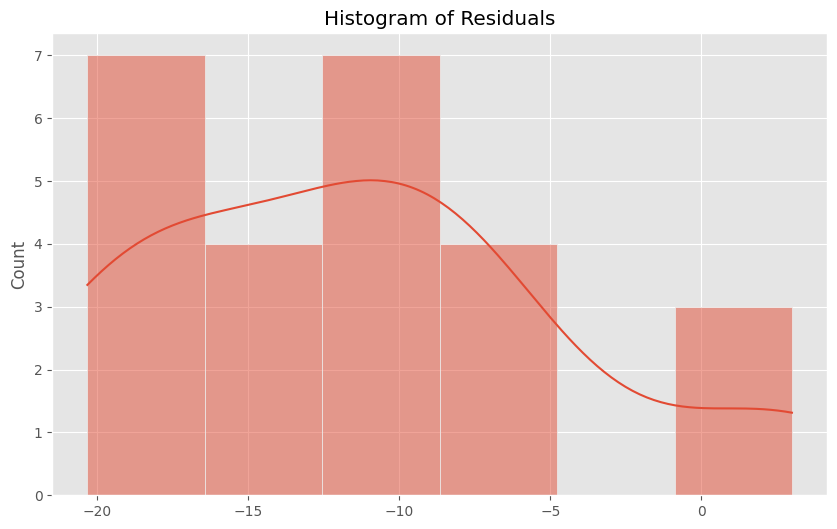

In [20]:
# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

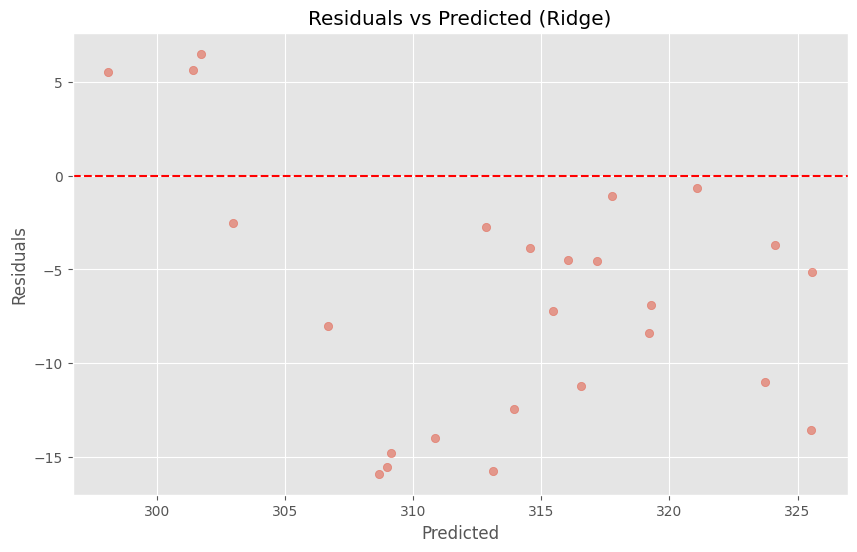

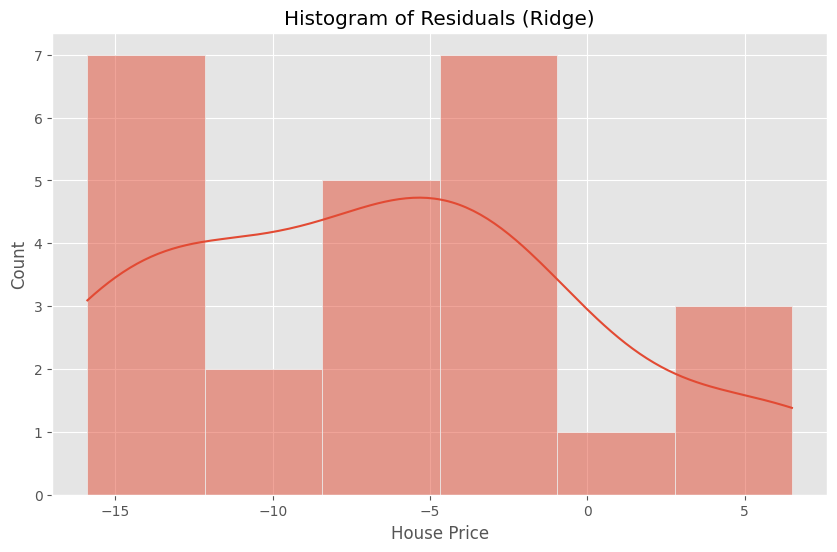

In [21]:
ridge_pred = ridge.predict(X_test_scaled)

ridge_residuals = y_test - ridge_pred

# Residuals vs Predicted for Ridge
plt.figure(figsize=(10, 6))
plt.scatter(ridge_pred, ridge_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Ridge)')
plt.show()

# Histogram of Residuals for Ridge
plt.figure(figsize=(10, 6))
sns.histplot(ridge_residuals, kde=True)
plt.title('Histogram of Residuals (Ridge)')
plt.show()

In [22]:
ridge_coefficients = ridge.coef_
ridge_intercept = ridge.intercept_
feature_names = ['const'] + list(X_train.columns)
coef_df = pd.DataFrame({'Feature': feature_names,'Coefficient': np.concatenate([[ridge_intercept], ridge_coefficients])})
coef_df

,Feature,Coefficient
0,const,137.893540
1,30-Year Fixed Rate Mortgage,1.632251
2,10-Year Treasury Yield,6.753670
3,Federal Funds Rate,5.404879
4,"All Employees, Retail Trade",0.326396
5,Median CPI,59.593774
6,Unemployment Rate,-9.431179
7,Consumer Sentiment,-7.794603


In [23]:
ridge

Ridge()

### Potential Extensions:

1. **Time Series Analysis**: Incorporate lagged variables and autoregressive models to account for temporal dependencies and trends within the data. This approach can enhance the model's ability to capture time-related patterns and improve forecasting accuracy.

2. **Non-Linear Models**: Explore non-linear relationships between features and the target variable.